# VT2

In [120]:
# Import of Packages
import numpy as np
import pandas as pd
import statistics as st
import time

# Import of Packages for Functions
import math
import matplotlib.pyplot as plt
import sys

# Importing the Functions File
import Functions_VT2 as fn

# Start of Timer to Measure Runtime
start_time = time.time()

## Scenario Generation

In [121]:
# Demand at t0
Dt0 = 22561132
# Steptime in Years
dt = 1
# Time Horizon of Forecasts in Steptime
Fth = 20
# Number of Forecasts
Forecasts = 100

# Parameters
mu = 0.042754330256447565
sigma = 0.05813761525452841

### Plotting the Scenarios

[[25878656. 26065349. 26381275. ... 40221385. 42081464. 45433294.]
 [22087141. 24638282. 27098329. ... 40160281. 46160744. 50300990.]
 [23285482. 23080308. 23064534. ... 57691291. 61219387. 67267570.]
 ...
 [26090057. 25119488. 23070397. ... 46221511. 48559480. 49732767.]
 [23041489. 22255601. 20634936. ... 30538875. 31993006. 34489476.]
 [23367027. 27670711. 30924875. ... 44588689. 48321248. 54666574.]]


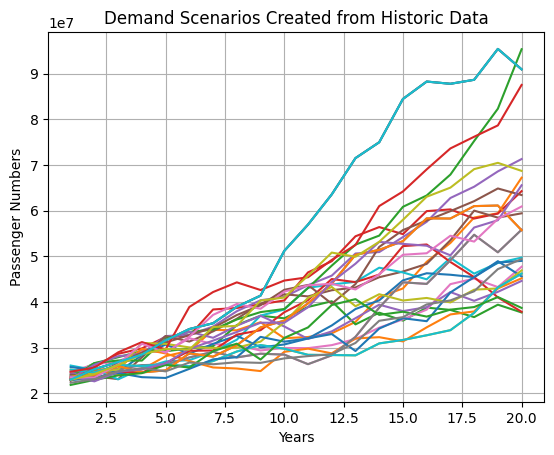

<Figure size 640x480 with 0 Axes>

In [122]:
# Calling the Scenario Creation Function
Scenarios = fn.generate_scenarios(mu, sigma, Dt0, dt, Fth, Forecasts)

# Round values up for further Calculation
D = np.ceil(Scenarios)
print(D)


# Calling the Scenario Plotting Function
fn.Scenario_plot(
    Scenarios,
    Fth,
    True,
    "Demand Scenarios Created from Historic Data",
    "Passenger Numbers",
    30,
)

# print(np.shape(Scenarios))
# print(Scenarios)

Geometric Brownian motion Formula

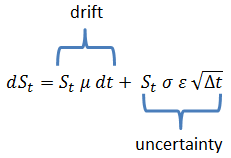

## Estimation of Dockstand Demand

In [123]:
# Percentage of Pax using Dock Stands rather than Bus Gates
p_dock = 0.8
# Percentage of Pax travelling within Schengen Area
p_schengen = 0.8
# Percentage of Pax travelling from Dock
p_Dok_A_B = 0.5
# average number of passengers carried per air traffic movement
PAXATM = 114

# Demand at design Hour
D_per_hour = D / (365 * 17)

# Contact Stand Demand (ZRH has 75, but not all can be used at once)
# Dock A has 17 Contact and 16 Bus Gates

d = (D_per_hour * p_dock * p_schengen * p_Dok_A_B) / PAXATM

# print("Contact Stand demad d: ", d)

### Plotting the Dockstand demand

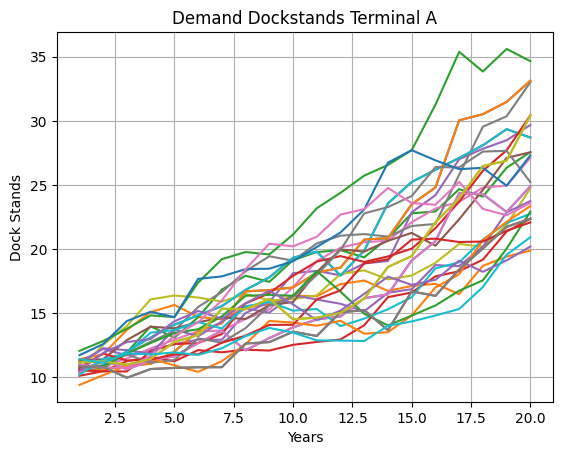

<Figure size 640x480 with 0 Axes>

In [124]:
# Calling the Scenario Plotting Function
fn.Scenario_plot(
    d,
    Fth,
    True,
    "Demand Dockstands Terminal A",
    "Dock Stands",
    30,
)

## Calulation of the NPV

In [ ]:
# NPV

### Stopping the Runtime

In [125]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime =", total_run_time)

Total Runtime = 0.7375426292419434
